In [1]:
import numpy as np
import ROOT
from math import exp as expo
from math import cos as cosine
exp=np.vectorize(expo)
cos=np.vectorize(cosine)
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
import scipy.optimize as opt

Welcome to JupyROOT 6.24/06


In [2]:
file = ROOT.TFile.Open("run3b_NE_305stop_mulife_64413.root");
#direc = file.Get("QFillByFillAnalyzerDB")
hist = ROOT.TH1D()
hist = file.Get("calo_histogram_sum_ratio")
hcov = ROOT.TH2D()
hcov = file.Get("hcov")

In [3]:
getBlinded = Blinders(FitType.Omega_a, "Ritwika's new  Blinding")

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [4]:
fit_start=30000
fit_stop=305000
fit_range=hist.FindBin(fit_stop)-hist.FindBin(fit_start)+1

T_a_true=4365.411
nbinshift=int((0.5*T_a_true)/hist.GetBinWidth(1))
T_a=2*nbinshift*hist.GetBinWidth(1)

y_val=np.empty(fit_range)
y_err=np.empty(fit_range)
x_val=np.empty(fit_range)

for ibin in range (0,fit_range):
    y_val[ibin]=hist.GetBinContent(ibin+hist.FindBin(fit_start))
    y_err[ibin]=hist.GetBinError(ibin+hist.FindBin(fit_start))
    x_val[ibin]=hist.GetBinCenter(ibin+hist.FindBin(fit_start))

y_cov = np.empty(shape=(fit_range,fit_range))

for irow in range (0, fit_range):
      for icol in range(0, fit_range):
            y_cov[irow][icol]=hcov.GetBinContent(irow+hist.FindBin(fit_start),icol+hist.FindBin(fit_start))

In [5]:
print(y_cov[0][0])
mat=np.linalg.eigvalsh(y_cov)
for irow in range (0, fit_range):
    if mat[irow]<=0:
        print(irow,"\n")

8.270095283876686e-09


In [6]:
def fit_func(time: np.double,
             asym: np.double = 0.0, 
             R: np.double = 0.0, 
             phi: np.double = 0.0,
             asym_cbo = 0.0,
             tau_cbo = 0.0,
             omega_cbo = 0.0,
             phi_cbo = 0.0,
             asym_cbo_A = 0.0,
             phi_cbo_A=0.0,
             A_cbo_phi= 0.0,
             phi_cbo_phi=0.0,
             asym_vw= 0.0,
             tau_vw = 0.0,
             omega_vw = 0.0,
             phi_vw = 0.0,
             asym_vbo= 0.0,
             tau_vbo = 0.0,
             omega_vbo = 0.0,
             phi_vbo = 0.0,
             asym_2cbo= 0.0,
             phi_2cbo = 0.0,
             tau_rlx = 0.0,
             #A_cbot = 0.0,
             #tau_cbot = 0.0,
             A_cbovw = 0.0,
             phi_cbovw = 0.0,
             A_drift = 0.0)-> np.double:
    
    tau_cbovw = 34200
    omega_cbovw = 0.01204
    A_cbot = 0
    tau_cbot=1000000000000000000
    
    tau_drift = 13500
    
    omega_cbot=omega_cbo*(1+A_cbot*exp(-time/tau_cbot))
    omega_cbotf=omega_cbo*(1+A_cbot*exp(-(time+T_a/2)/tau_cbot))
    omega_cbotb=omega_cbo*(1+A_cbot*exp(-(time-T_a/2)/tau_cbot))
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo))
    
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo_A))
    
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo_phi))
    
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    
    N2cbo=(asym_2cbo*exp(-2*time/tau_cbo)*cos(2*omega_cbot*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-2*(time + T_a/2)/tau_cbo)*cos(2*omega_cbotf*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-2*(time - T_a/2)/tau_cbo)*cos(2*omega_cbotb*(time - T_a/2) - phi_2cbo))
    
    Ncbovw=(1+ A_cbovw*exp(-time/tau_cbovw)*cos(omega_cbovw*time - phi_cbovw))
    Ncbovwf=(1+ A_cbovw*exp(-(time + T_a/2)/tau_cbovw)*cos(omega_cbovw*(time + T_a/2) - phi_cbovw))
    Ncbovwb=(1+ A_cbovw*exp(-(time - T_a/2)/tau_cbovw)*cos(omega_cbovw*(time - T_a/2) - phi_cbovw))

    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob
    
    
    Ndrift =  (1 + A_drift * exp (-time/tau_drift))
    Ndriftf =  (1 + A_drift * exp (-(time + T_a/2)/tau_drift))
    Ndriftb =  (1 + A_drift * exp (-(time - T_a/2)/tau_drift))

    
    f=(1+ asym*exp(-time/tau_rlx)*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*exp(-(time+T_a/2)/tau_rlx)*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*exp(-(time-T_a/2)/tau_rlx)*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo*Ncbovw*Ndrift - ff*Ncbof*Nvwf*Nvbof*Ncbovwf*Ndriftf - fb*Ncbob*Nvwb*Nvbob*Ncbovwb*Ndriftb)/(2*f*Ncbo*Nvw*Nvbo*Ncbovw*Ndrift + ff*Ncbof*Nvwf*Nvbof*Ncbovwf*Ndriftf + fb*Ncbob*Nvwb*Nvbob*Ncbovwb*Ndriftb)

In [7]:
p_init=[0.2282,
        0.000000,
        4.02000e+00,
        2.42604e-03,
        204100,
        2.331e-03,
        2.500e+00,
        0.0004,
        3.1,
        6.39026e-05,
        3.5,
        0.0007,
        57300,
        0.0139,
        2.7,
        0.0004,
        19000,
        0.01405,
        1.9,
        1.10668e-04,
        3.06805,
        7.7000e+08,
        #-0.007,
        #54700,
        0.00014,
        4.2,
        0.001]

In [8]:
pars2, cov2 = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_err)

In [9]:
p_init=pars2

In [10]:
pars_final, cov_final = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_cov)

In [11]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov_final))

In [12]:
for ipar in range(0,24):
    print(pars_final[ipar],"       +-  ",stdevs[ipar],"  \n")

0.2282437424689544        +-   2.09534944022649e-05   

-34.02252734440697        +-   0.6110024395429936   

3.996703110994368        +-   9.311984773428612e-05   

-0.0011262801721409785        +-   3.3249359467754614e-05   

211417.47013834034        +-   16632.472222813292   

0.0023311271035070472        +-   3.73720975274948e-07   

2.5722146756918636        +-   0.029751180188404586   

-0.00037508309833302376        +-   9.963937882953438e-05   

2.240489402498097        +-   0.2633434547633512   

0.00012419874273373113        +-   0.00010087870772157749   

1.403823269108664        +-   0.8081143969274348   

-0.0007507982302067085        +-   0.00010704009546839444   

54468.41969688649        +-   7162.062735148485   

0.01390025984100868        +-   2.4053416299873014e-06   

2.677301521874996        +-   0.14170139057316544   

0.002987005528812217        +-   0.0005276120797350627   

21127.966605471443        +-   1892.746490659261   

0.014048950509291653        +-   4

In [13]:
pars_final

array([ 2.28243742e-01, -3.40225273e+01,  3.99670311e+00, -1.12628017e-03,
        2.11417470e+05,  2.33112710e-03,  2.57221468e+00, -3.75083098e-04,
        2.24048940e+00,  1.24198743e-04,  1.40382327e+00, -7.50798230e-04,
        5.44684197e+04,  1.39002598e-02,  2.67730152e+00,  2.98700553e-03,
        2.11279666e+04,  1.40489505e-02,  1.96042505e+00,  2.48878633e-05,
        3.50108292e+00,  5.28143400e+08, -6.87989010e-04, -2.58247193e+01,
       -7.56225593e-03])

In [14]:
stdevs

array([2.09534944e-05, 6.11002440e-01, 9.31198477e-05, 3.32493595e-05,
       1.66324722e+04, 3.73720975e-07, 2.97511802e-02, 9.96393788e-05,
       2.63343455e-01, 1.00878708e-04, 8.08114397e-01, 1.07040095e-04,
       7.16206274e+03, 2.40534163e-06, 1.41701391e-01, 5.27612080e-04,
       1.89274649e+03, 4.20242647e-06, 1.74444447e-01, 2.16542936e-05,
       8.69509338e-01, 2.40881175e+08, 3.76611777e-04, 5.47420260e-01,
       2.56727819e-03])

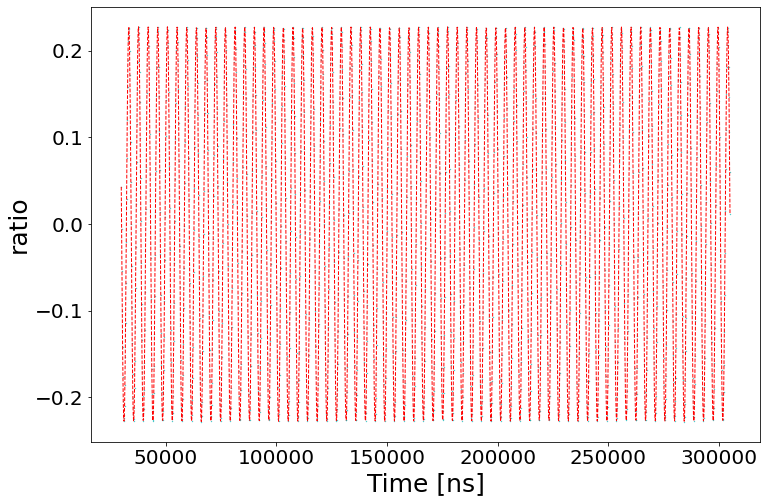

In [15]:
# Plot the noisy exponential data
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.scatter(x_val, y_val, s=0.1, color='#00b3b3', label='Data')
plt.plot(x_val, fit_func(x_val, *pars_final), linestyle='--', linewidth=1, color='red')
plt.xlabel('Time [ns]',fontsize=25)
plt.ylabel('ratio',fontsize=25)
#plt.ylim([0.0, 6000000000])
#plt.xlim([100000,150000])
plt.show()

In [16]:
# Calculate the residuals
res = (y_val - fit_func(x_val, *pars_final))/y_err

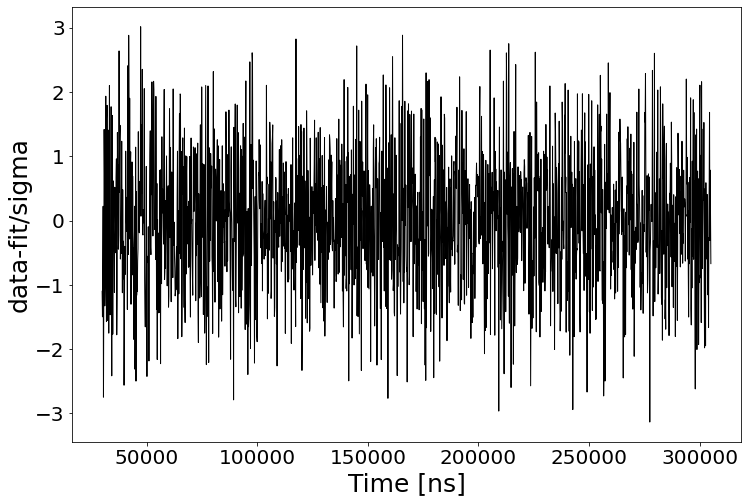

In [17]:
# Plot the noisy exponential data
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.plot(x_val, res, linestyle='solid', linewidth=1, color='black')
plt.xlabel('Time [ns]',fontsize=25)
plt.ylabel('data-fit/sigma',fontsize=25)
plt.savefig('run2all_res.jpg')

In [18]:
stdevs

array([2.09534944e-05, 6.11002440e-01, 9.31198477e-05, 3.32493595e-05,
       1.66324722e+04, 3.73720975e-07, 2.97511802e-02, 9.96393788e-05,
       2.63343455e-01, 1.00878708e-04, 8.08114397e-01, 1.07040095e-04,
       7.16206274e+03, 2.40534163e-06, 1.41701391e-01, 5.27612080e-04,
       1.89274649e+03, 4.20242647e-06, 1.74444447e-01, 2.16542936e-05,
       8.69509338e-01, 2.40881175e+08, 3.76611777e-04, 5.47420260e-01,
       2.56727819e-03])

In [19]:
fou=abs(np.fft.fft(res))

In [20]:
#xfft=np.empty(fit_range)
xfft= np.linspace(0,6.667,num=fit_range)
xfft[800]

2.9081788440567067

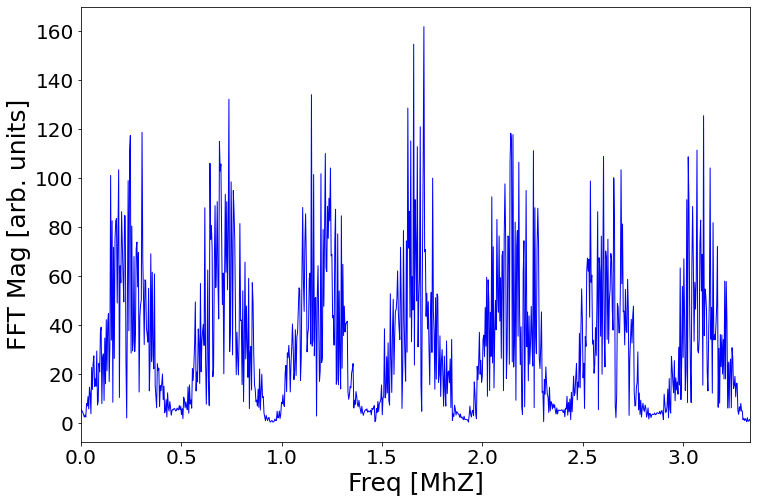

In [21]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.plot(xfft, fou, linestyle='solid', linewidth=1, color='blue')
plt.xlim([0,6.667/2])
plt.xlabel('Freq [MhZ]',fontsize=25)
plt.ylabel('FFT Mag [arb. units]',fontsize=25)
plt.savefig('run2all_fft.jpg')

In [22]:
chi2=np.dot((np.transpose(y_val-fit_func(x_val, *pars_final))),(np.dot((np.linalg.inv(y_cov)),(y_val-fit_func(x_val, *pars_final)))))

In [23]:
chi2

1798.480445296466

In [24]:
ndf=fit_range-len(pars_final)

In [25]:
red_chi2=chi2/ndf

In [26]:
red_chi2

0.9935168332927062

In [27]:
ndf

1810